## Importar librerias

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import f1_score
import random

## Leer bases

In [4]:
base_modelo = "../input/base_modelo_alto_valor.parquet"

In [5]:
df = pd.read_parquet(base_modelo)

In [6]:
df.shape

(84716, 43)

## Modelo base con parámetros óptimos

In [7]:
# Separar las características y el objetivo
X = df[['periodo_creacion', 'flg_vip', 'tipo_producto_producto_a', 'tipo_producto_producto_b', 'tipo_producto_producto_c', 'monto_1m', 'monto_2m', 'monto_3m', 
        'cantidad_1m', 'cantidad_2m', 'cantidad_3m',
        'ultima_compra_1m', 'crossell']]  # Características
y = df['flg_churn']  # Variable objetivo

# Realizar el train-test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,  # 30% para el conjunto de prueba
    stratify=y,  # Estratificación por la variable objetivo
    random_state=42  # Semilla para reproducibilidad
)

## Modelo base 

In [8]:
def entrenar_xgboost_rapido(X_train, X_test, y_train, y_test):
    """
    Entrena un modelo XGBoost para un problema de clasificación binaria utilizando
    parámetros óptimos previamente obtenidos.
    """
    # Parámetros óptimos (reemplaza con los que obtuviste en el GridSearch)
    parametros_optimos = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'n_estimators': 50,
        'max_depth': 5,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }
    
    # Crear y entrenar el modelo
    xgb_model = xgb.XGBClassifier(**parametros_optimos)
    xgb_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = xgb_model.predict(X_test)
    y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
    
    # Evaluar el modelo
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    return xgb_model

In [9]:
modelo_final = entrenar_xgboost_rapido(X_train, X_test, y_train, y_test)


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24834
           1       0.67      0.47      0.55       581

    accuracy                           0.98     25415
   macro avg       0.83      0.73      0.77     25415
weighted avg       0.98      0.98      0.98     25415

AUC-ROC: 0.9187
Accuracy: 0.9826


## Entrenar modelos con seleccion de variable GA

In [12]:
def feature_selection_ga(X, y, generations=10, population_size=20, mutation_rate=0.3, tournament_size=3, seleccion = "tournament"):
    """
    Realiza selección de características usando un algoritmo genético con XGBoost como modelo base.
    Se puede utilizar el algoritmo de xgboost o random forest
    Se puede usar tounament selection o fitness scaling
    """
    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    n_features = X.shape[1]

    # Función para inicializar la población heurísticamente
    def initialize_population(size):
        population = []
        for _ in range(size):
            individual = np.random.choice([0, 1], size=n_features, p=[0.5, 0.5])
            population.append(individual)
        return np.array(population)

    # Función para evaluar el fitness
    def evaluate_fitness(individual):
        selected_features = np.where(individual == 1)[0]
        if len(selected_features) == 0:  # Penalizar soluciones sin características
            return 0
        X_train_selected = X_train.iloc[:, selected_features]
        X_test_selected = X_test.iloc[:, selected_features]
        
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        )
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return f1_score(y_test, y_pred, average='macro')

    # Selección por torneo
    def tournament_selection(population, fitness_scores, k):
        selected = []
        for _ in range(k):
            participants = np.random.choice(len(population), size=tournament_size, replace=False)
            best = participants[np.argmax(fitness_scores[participants])]
            selected.append(population[best])
        return np.array(selected)
    
    def fitness_scaling_selection(population, fitness_scores, k):
        # Escalar los valores de fitness: normaliza entre 0 y 1
        min_fitness = np.min(fitness_scores)
        max_fitness = np.max(fitness_scores)
        
        if max_fitness == min_fitness:  # Evitar división por cero
            scaled_fitness = np.ones_like(fitness_scores)
        else:
            scaled_fitness = (fitness_scores - min_fitness) / (max_fitness - min_fitness)
        
        # Convertir los valores escalados en probabilidades de selección
        selection_probabilities = scaled_fitness / np.sum(scaled_fitness)
        
        # Seleccionar individuos basados en las probabilidades
        selected_indices = np.random.choice(len(population), size=k, replace=True, p=selection_probabilities)
        selected = population[selected_indices]
        
        return np.array(selected)
    
    # Cruce (crossover)
    def crossover(parent1, parent2):
        point = random.randint(1, n_features - 1)
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
        return child1, child2

    # Mutación
    def mutate(individual):
        for i in range(len(individual)):
            if random.random() < mutation_rate:
                individual[i] = 1 - individual[i]
        return individual

    # Inicializar población
    population = initialize_population(population_size)
    best_fitness = 0
    best_solution = None
    historial_fitness = []  # Para almacenar el mejor F1 Score de cada generación

    # Algoritmo genético
    for generation in range(generations):
        fitness_scores = np.array([evaluate_fitness(ind) for ind in population])
        
        # Guardar el mejor individuo
        if fitness_scores.max() > best_fitness:
            best_fitness = fitness_scores.max()
            best_solution = population[np.argmax(fitness_scores)]
        
        # Almacenar el mejor F1 Score de la generación
        historial_fitness.append(best_fitness)
        
        print(f"Generación {generation + 1} - Mejor F1 Score: {best_fitness:.4f}")
        
         # Selección
        if seleccion == "tournament":
            selected_population = tournament_selection(population, fitness_scores, population_size // 2)
        else:
            selected_population = fitness_scaling_selection(population, fitness_scores, population_size // 2)
        
        # Reproducción
        next_population = []
        while len(next_population) < population_size:
            parent1, parent2 = random.sample(list(selected_population), 2)
            child1, child2 = crossover(parent1, parent2)
            next_population.extend([mutate(child1), mutate(child2)])
        
        population = np.array(next_population[:population_size])

    # Extraer nombres de las mejores características
    selected_features_indices = np.where(best_solution == 1)[0]
    nombres_mejores_caracteristicas = X.columns[selected_features_indices].tolist()

    return best_solution, nombres_mejores_caracteristicas, historial_fitness

### Xgboost + tournament

In [13]:
df_numeric = df.select_dtypes(include=['number'])

In [23]:
df_numeric

,periodo,id_cliente,tasa,monto_1m,monto_2m,monto_3m,monto_4m,monto_5m,monto_6m,cantidad_1m,...,segmento_1,segmento_2,segmento_3,segmento_4,segmento_5,segmento_6,segmento_7,segmento_8,segmento_9,segmento_10
18,202404,2,0.0344,9.188453,5.150397,7.817021,-16.118096,8.383090,8.793536,5.236442,...,0,0,1,0,0,0,0,0,0,0
19,202405,2,0.0344,9.099744,9.188453,5.150397,7.817021,-16.118096,8.383090,5.181784,...,0,0,1,0,0,0,0,0,0,0
255,202404,26,0.0299,8.600063,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096,5.036953,...,0,1,0,0,0,0,0,0,0,0
256,202405,26,0.0299,9.747038,8.600063,-16.118096,-16.118096,-16.118096,-16.118096,6.129050,...,0,1,0,0,0,0,0,0,0,0
257,202406,26,0.0299,9.782929,9.747038,8.600063,-16.118096,-16.118096,-16.118096,6.129050,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391676,202405,161018,0.0344,8.962366,8.445117,8.978938,9.024179,9.186375,8.871295,4.418841,...,1,0,0,0,0,0,0,0,0,0
1391677,202406,161018,0.0344,8.754539,8.962366,8.445117,8.978938,9.024179,9.186375,4.543295,...,1,0,0,0,0,0,0,0,0,0
1391678,202407,161018,0.0344,9.100436,8.754539,8.962366,8.445117,8.978938,9.024179,4.736198,...,1,0,0,0,0,0,0,0,0,0
1391679,202408,161018,0.0344,8.848409,9.100436,8.754539,8.962366,8.445117,8.978938,4.418841,...,1,0,0,0,0,0,0,0,0,0


In [24]:
best_solution, nombres_mejores_caracteristicas, historial_fitness = feature_selection_ga(df_numeric.drop(columns=["id_cliente", "periodo" ,"flg_churn"]), df_numeric[["flg_churn"]], generations=30, population_size=30, seleccion = "tournament")

Generación 1 - Mejor F1 Score: 0.7916
Generación 2 - Mejor F1 Score: 0.8025
Generación 3 - Mejor F1 Score: 0.8045
Generación 4 - Mejor F1 Score: 0.8045
Generación 5 - Mejor F1 Score: 0.8094
Generación 6 - Mejor F1 Score: 0.8094
Generación 7 - Mejor F1 Score: 0.8094
Generación 8 - Mejor F1 Score: 0.8094
Generación 9 - Mejor F1 Score: 0.8094
Generación 10 - Mejor F1 Score: 0.8094
Generación 11 - Mejor F1 Score: 0.8094
Generación 12 - Mejor F1 Score: 0.8094
Generación 13 - Mejor F1 Score: 0.8094
Generación 14 - Mejor F1 Score: 0.8094
Generación 15 - Mejor F1 Score: 0.8094
Generación 16 - Mejor F1 Score: 0.8094
Generación 17 - Mejor F1 Score: 0.8094
Generación 18 - Mejor F1 Score: 0.8094
Generación 19 - Mejor F1 Score: 0.8094
Generación 20 - Mejor F1 Score: 0.8094
Generación 21 - Mejor F1 Score: 0.8094
Generación 22 - Mejor F1 Score: 0.8094
Generación 23 - Mejor F1 Score: 0.8094
Generación 24 - Mejor F1 Score: 0.8094
Generación 25 - Mejor F1 Score: 0.8094
Generación 26 - Mejor F1 Score: 0.

### Xgboost + fitness scaling

In [25]:
best_solution_fs, nombres_mejores_caracteristicas_fs, historial_fitness_fs= feature_selection_ga(df_numeric.drop(columns=["id_cliente", "periodo" ,"flg_churn"]), df_numeric[["flg_churn"]], generations=30, population_size=30, seleccion = "fitness_scaling")

Generación 1 - Mejor F1 Score: 0.8037
Generación 2 - Mejor F1 Score: 0.8037
Generación 3 - Mejor F1 Score: 0.8037
Generación 4 - Mejor F1 Score: 0.8057
Generación 5 - Mejor F1 Score: 0.8057
Generación 6 - Mejor F1 Score: 0.8057
Generación 7 - Mejor F1 Score: 0.8057
Generación 8 - Mejor F1 Score: 0.8057
Generación 9 - Mejor F1 Score: 0.8057
Generación 10 - Mejor F1 Score: 0.8057
Generación 11 - Mejor F1 Score: 0.8057
Generación 12 - Mejor F1 Score: 0.8057
Generación 13 - Mejor F1 Score: 0.8057
Generación 14 - Mejor F1 Score: 0.8057
Generación 15 - Mejor F1 Score: 0.8057
Generación 16 - Mejor F1 Score: 0.8057
Generación 17 - Mejor F1 Score: 0.8057
Generación 18 - Mejor F1 Score: 0.8057
Generación 19 - Mejor F1 Score: 0.8057
Generación 20 - Mejor F1 Score: 0.8057
Generación 21 - Mejor F1 Score: 0.8057
Generación 22 - Mejor F1 Score: 0.8057
Generación 23 - Mejor F1 Score: 0.8057
Generación 24 - Mejor F1 Score: 0.8057
Generación 25 - Mejor F1 Score: 0.8057
Generación 26 - Mejor F1 Score: 0.

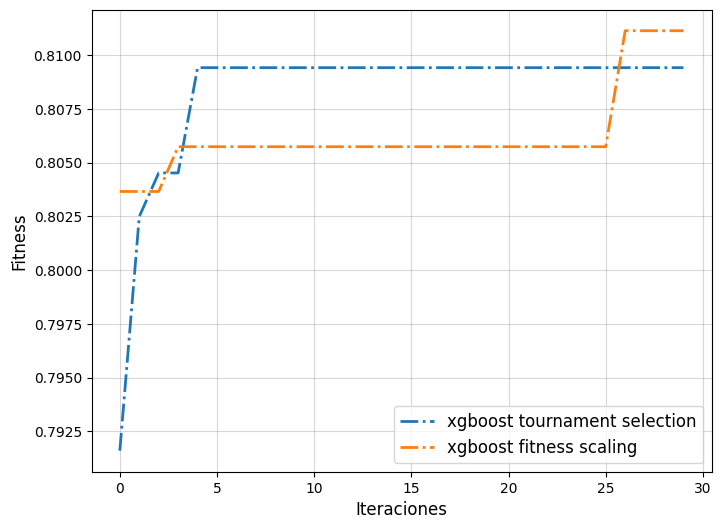

In [26]:
# Crear el gráfico
plt.figure(figsize=(8, 6))  # Tamaño del gráfico
plt.plot([i for i in range(len(historial_fitness))], historial_fitness[:], label="xgboost tournament selection", linestyle="-.", linewidth=2)
plt.plot([i for i in range(len(historial_fitness_fs))], historial_fitness_fs[:], label="xgboost fitness scaling", linestyle="-.", linewidth=2)

# Personalización
#plt.title("F1 Score compartivo Torunament Selection vs Fitness Scaling", fontsize=16)
plt.xlabel("Iteraciones", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

plt.show()

## Modelo final

In [27]:
nombres_mejores_caracteristicas

['tasa',
 'monto_2m',
 'monto_3m',
 'cantidad_2m',
 'frecuencia_1m',
 'frecuencia_2m',
 'ultima_compra_1m',
 'segmento_pago',
 'incidencias_b',
 'tipo_producto_producto_a',
 'tipo_producto_producto_b',
 'tipo_producto_producto_c',
 'segmento_1',
 'segmento_2',
 'segmento_3',
 'segmento_4',
 'segmento_6',
 'segmento_10']

In [28]:
# Separar las características y el objetivo
X = df[nombres_mejores_caracteristicas]  # Características
y = df['flg_churn']  # Variable objetivo

# Realizar el train-test split estratificado
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, 
    test_size=0.3,  # 30% para el conjunto de prueba
    stratify=y,  # Estratificación por la variable objetivo
    random_state=42  # Semilla para reproducibilidad
)

modelo_final_2 = entrenar_xgboost_rapido(X_train_final, X_test_final, y_train_final, y_test_final)


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24834
           1       0.69      0.56      0.62       581

    accuracy                           0.98     25415
   macro avg       0.84      0.78      0.80     25415
weighted avg       0.98      0.98      0.98     25415

AUC-ROC: 0.9423
Accuracy: 0.9842
